## Logistic Regression with SGD

To begin you first need to install all dependencies, using:

    pip install -r requirements.txt

In [174]:
import numpy as np
import matplotlib.pyplot as plt

from math import exp, log
import os
import pickle

from skimage import io
from skimage.color import rgb2gray
from skimage.feature import hog

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve, auc
import random
from sklearn.utils.fixes import signature
from sklearn.metrics import average_precision_score

In [3]:
%matplotlib inline

### load the dataset

In [4]:
### set your image dir here
IMAGE_DIR = "/Users/astitvnagpal/Ghost_Files/SBU/Sem1/ML/HomeWork/HW3/upload_folder/"

In [5]:
def load_dataset(subset="train"):
    """
    1. subset = "train", "val", "test"
    2. About the dataset: in "train","val" subset, the first half of images are images of hands, the rest half are images of not-hand. 
    3. extract features from HoG
    """
    path = os.path.join(IMAGE_DIR,subset)
    name_list = os.listdir(path)
    print("Number of images in {}-set: {}".format(subset, len(name_list)))
    #HoG returns 324 features
    X = np.zeros(shape=(len(name_list), 324))

    if subset == "train" or subset == "val":
        #Make sure that we have equal number of positive and negative class images
        assert len(name_list)%2 == 0
        count = len(name_list)//2
        y = np.array(count*[1] + count*[0])
        for idx_true in range(count):
            img_name = os.path.join(path,str(idx_true)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_true, :] = vec
        
        for idx in range(count):
            idx_false = idx + count
            img_name = os.path.join(path,str(idx_false)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx_false, :] = vec
        return X, y        
    else:
        for idx in range(len(name_list)):
            img_name = os.path.join(path, str(idx)+".png")
            img = io.imread(img_name)
            img = rgb2gray(img)
            vec = hog(img)
            X[idx, :] = vec
        return X

### load the data

In [6]:
X_train, y_train = load_dataset("train")
X_val, y_val = load_dataset("val")
X_test = load_dataset("test")

Number of images in train-set: 8170


/anaconda3/lib/python3.6/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Number of images in val-set: 2724
Number of images in test-set: 5542


In [ ]:
# This was for my practice and understanding 
# Kindly ignore these cells
# *******************   From here  *************************

In [381]:
X_train.shape

(8170, 324)

In [382]:
X_val.shape

(2724, 324)

In [145]:
eve = np.hstack((np.transpose(X_train), np.transpose(X_val)))

In [146]:
eve_x = np.transpose(eve)

In [147]:
eve_x.shape

(10894, 324)

In [148]:
eve_y = np.hstack((np.transpose(y_train), np.transpose(y_val)))

In [149]:
eve_y = np.transpose(eve_y)

In [150]:
eve_y.shape

(10894,)

In [151]:
y_train.shape

(8170,)

In [ ]:
#. Ignore
# ***************************** Till Here  **************************

### displaying images

In [7]:
def display(img_path):
    """
    visualize the img
    """
    img = io.imread(img_path)
    print(img_path)
    io.imshow(img)
    io.show()

/Users/astitvnagpal/Ghost_Files/SBU/Sem1/ML/HomeWork/HW3/upload_folder/train/1.png


/anaconda3/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


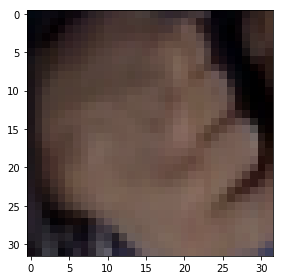

In [8]:
display(IMAGE_DIR+"train/1.png")

### Logistic regression

#### Main function in the class
1. \__init\__() which sets the hyper parameters
2. sigmoid()
3. __init_param(), initializes the parameters .
4. fit(): train the data
5. predict_proba(): predict the probability of the sample belonging to the positive class
6. predict(): classify the sample


Feel free to overlook the rest of the parts of the code, it's just for convenience.


In [60]:
class LogisticRegression:
    """
    Logistic Regression
    """
    def __init__(self, eta0=0.1, eta1=1, m=16, max_epoch=1000, delta=0.0001):
        """
        m is the batch_size
        """
        self.__init = True # whether to initial the parameters
        self.__eta0 = eta0
        self.__eta1 = eta1
        self.__delta = delta
        self.__m = m
        self.__max_epoch = max_epoch
        
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    def __init_param(self):
        """
        Weights initialized using a normal distribution here: you can change the distribution.
        """
        d = self.__dimension
        self.__wt = np.random.randn(1,d)
        self.__bias = np.random.randn()
        return self.__wt,self.__bias
     
    def getBatch(self, X, y, size):
        batches_list = []
        for i in np.arange(0, X.shape[1], size):
            batches_list.append((X[:, i:i + size], y[i:i + size]))
        return batches_list
    
    def loss(self, X, y, theta):
        part1 = np.log(self.sigmoid(np.dot(np.transpose(theta), np.transpose(X))))
        part2 = np.log(1 - self.sigmoid(np.dot(np.transpose(theta), np.transpose(X))))
        ans = np.dot(np.transpose(-y), np.transpose(part1)) - np.dot(np.transpose((1-y)), np.transpose(part2))
        ans = ans/y.shape[0]
        return ans
                    
    def fit(self, X, y, X_val=None, y_val=None):
        """
        Recommended input:
        X: n x d array,
        y: n x 1 array or list
        """
        n, d = X.shape
        self.__dimension = d
        
        if self.__init:
            self.__init_param()
        
        theta_first = np.append(self.__wt, self.__bias)
        theta_first = np.reshape(theta_first, (len(theta_first),1))
        ones = [1]*n
        X_t = np.transpose(X)
        y = np.reshape(y,(X.shape[0],1))
        y_t = np.transpose(y)
        X_t_b = np.vstack((X_t, ones))
        theta = theta_first
        
        theta_epoch_list = []
        epoch_value_list = []
        theta_loss_list = []
        accuracy_per_epoch_list = []
        
        for i in range(1, self.__max_epoch+1):
            
            eta = self.__eta0/(i+self.__eta1)
            comb = np.hstack([np.transpose(X_t_b), y])
            np.random.shuffle(comb)
            X_s = comb[:,:-1]
            y_s = comb[:,-1]
            y_s = np.reshape(y_s,(X_s.shape[0],1))
            y_s_t = np.transpose(y_s)
            X_s_t = np.transpose(X_s)
            for batch in self.getBatch(X_s_t, y_s, self.__m):
                X_batch = batch[0]
                y_batch = batch[1]
                exp = np.dot(np.transpose(theta), X_batch)
                sig = self.sigmoid(exp)
                ans = np.dot((sig - (np.transpose(y_batch))), np.transpose(X_batch))
                ans = ans/self.__m
                theta = theta - eta*np.transpose(ans)
                
            self.theta_final = theta
            predictions = self.predict(X)
            predictions = predictions[0]
            accuracy = accuracy_score(predictions, y)   
            
            loss_theta_new = self.loss(X_s, y_s, theta)
            loss_theta_old = (1-self.__delta)*self.loss(X_s, y_s, theta_first)
            
            theta_epoch_list.append(theta)
            epoch_value_list.append(i)
            theta_loss_list.append(loss_theta_new)
            accuracy_per_epoch_list.append(accuracy)
            
            if loss_theta_new > loss_theta_old:
                # Removig the last saved values as they will be bigger loss.
                theta_epoch_list = theta_epoch_list[:-1]
                epoch_value_list = epoch_value_list[:-1]
                theta_loss_list = theta_loss_list[:-1]
                accuracy_per_epoch_list = accuracy_per_epoch_list[:-1]
                break
                
            theta_first = theta
            
        self.theta_final = theta_epoch_list[-1]
        return theta_epoch_list, epoch_value_list, theta_loss_list, accuracy_per_epoch_list             
          
    
    def predict_proba(self, X):
        """
        predict the probility of the sample
        You can refer to my code below
        """
        n, d = X.shape
        ones = [1]*n
        X_t = np.transpose(X)
        X_t_b = np.vstack((X_t, ones))
        pred = self.sigmoid(np.dot(np.transpose(self.theta_final), X_t_b))
        return pred 
            
    def predict(self, X):
        """
        Classify the sample
        """
        return self.predict_proba(X) >= 0.5
    
    def get_param(self):
        """
        output:
            parameters: wt(1*d array), b(scalar)
        """
        return [self.__wt, self.__bias]
    
    def save_model(self, save_file):
        """
        save model to .pkl file
        """
        with open(save_file,"wb") as file:
            pickle.dump([self.__wt, self.__bias],file)

    def load_model(self, load_file):
        """
        load model from .pkl file
        """
        with open(load_file,"rb") as file:
            param = pickle.load(file)
        self.__wt = param[0]
        self.__bias = param[1]
        self.__init = False
        return self.__wt, self.__bias

## Question 2.3

### 1. Baseline Model

In [61]:
LR = LogisticRegression()
theta_epoch_list_train, epoch_value_list_train, theta_loss_list_train, acc_per_epoch_train = LR.fit(X_train,y_train)

In [62]:
pred_bool_train = LR.predict(X_train)
pred_train = pred_bool_train[0]
print(accuracy_score(pred_train, y_train))

0.8057527539779682


In [63]:
# Fetching the values out of the array
theta_loss_train = []
for i in range(len(theta_loss_list_train)):
    theta_loss_train.append(theta_loss_list_train[i][0][0])

(a) Number of epochs till termination = __

In [64]:
# Answer (a) : Number of epochs till termination:
print(epoch_value_list_train[-1])

339


Number of epochs till termination: = 399

In [ ]:
# (b) Plot L(theta) vs num_epochs

Text(0.5,1,'Loss(theta) vs Epoch_Value')

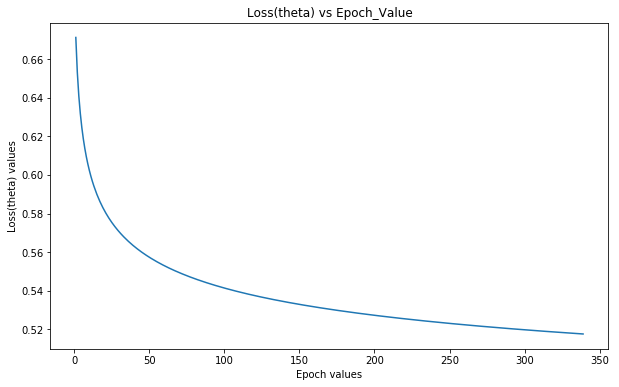

In [65]:
# Plotting Loss(theta) vs Epoch_Value
plt.figure(figsize=(10,6))
plt.plot(epoch_value_list_train, theta_loss_train)
plt.ylabel('Loss(theta) values')
plt.xlabel('Epoch values')
plt.title('Loss(theta) vs Epoch_Value')

(c) Final value of L($\theta$) after optimization = __

In [66]:
# (c) Final value of L(θ) after optimization = 
print(theta_loss_train[-1])

0.5176151929899254


Final value of L(θ) after optimization = 0.5176151929899254

### 2. Experimenting with ($\eta_0$,$\eta_1$)

In [ ]:
# Experimentation code goes here

In [75]:
eta0_list = []
theta_loss_values = []
for i in range(10,400, 10):
    LR = LogisticRegression(i)
    theta_epoch_list, epoch_value_list, theta_loss_list, acc_list = LR.fit(X_train,y_train)
    eta0_list.append(i)
    theta_loss_values.append(theta_loss_list[-1][0][0])

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


Text(0,0.5,'Loss(theta) values')

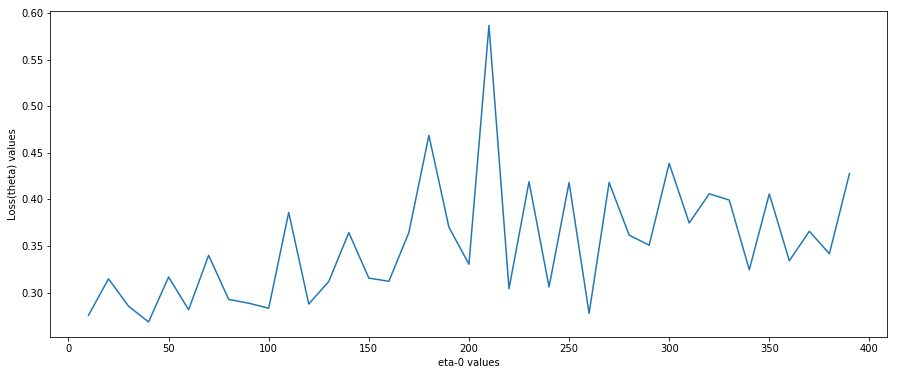

In [78]:
plt.figure(figsize=(15,6))
plt.plot(eta0_list, theta_loss_values)
plt.xlabel('eta-0 values')
plt.ylabel('Loss(theta) values')

eta-0 is performing best at around value 40. Using this value and checking for eta-1

In [82]:
eta1_list = []
theta_loss_values_1 = []
for i in range(1, 21, 1):
    LR = LogisticRegression(40, i/20)
    theta_epoch_list_1, epoch_value_list_1, theta_loss_list_1, acc_list_1 = LR.fit(X_train,y_train)
    eta1_list.append(i/20)
    theta_loss_values_1.append(theta_loss_list_1[-1][0][0])

Text(0,0.5,'Loss(theta) values')

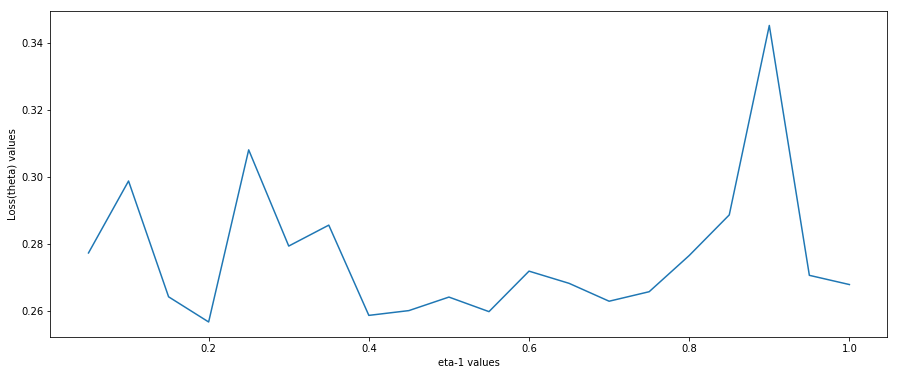

In [83]:
plt.figure(figsize=(15,6))
plt.plot(eta1_list, theta_loss_values_1)
plt.xlabel('eta-1 values')
plt.ylabel('Loss(theta) values')

We observe eta-1 performs best at value 0.2 for eta-0 at 40

In [132]:
LR = LogisticRegression(40, 0.2)
theta_epoch_list_exp, epoch_value_list_exp, theta_loss_list_exp, acc_list_exp = LR.fit(X_train,y_train)

In [133]:
# Fetching the values out of the array
theta_loss_exp = []
for i in range(len(theta_loss_list_exp)):
    theta_loss_exp.append(theta_loss_list_exp[i][0][0])

In [134]:
pred_bool_exp = LR.predict(X_train)
pred_exp = pred_bool_exp[0]
print(accuracy_score(pred_exp, y_train))

0.896328029375765


(a) Best value for, $\eta_0$ = \__, $\eta_1$ = \__

Number of epochs for training = __

Final value of L($\theta$) = __

In [186]:
# eta_0 = 40
# eta_1 = 0.2

# number of epochs = 
print(epoch_value_list_exp[-1])

# Final value of L(theta) = 
print(theta_loss_list_exp[-1][0][0])

4
0.26155505584268873


eta_0 = 40
eta_1 = 0.2
number of epochs = 4
Final value of L(theta) = 0.26155505584268873

In [108]:
# (b) For best (eta_0, eta_1) plot L(theta) vs num_epochs

Text(0,0.5,'Loss(theta) values')

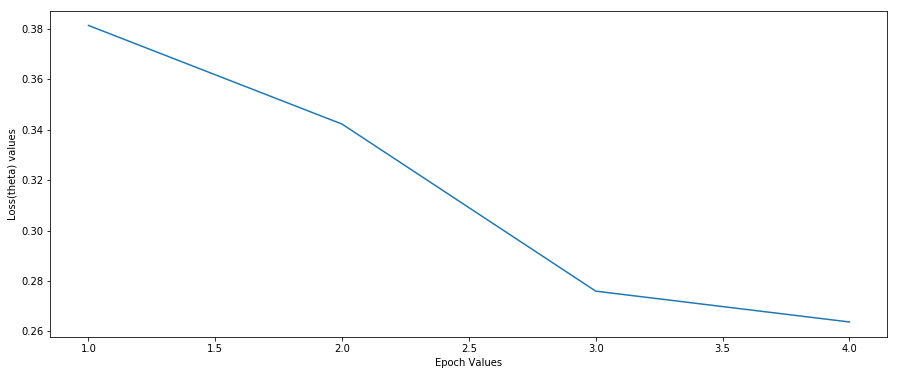

In [109]:
plt.figure(figsize=(15,6))
plt.plot(epoch_value_list_exp, theta_loss_exp)
plt.xlabel('Epoch Values')
plt.ylabel('Loss(theta) values')

### 3. Evaluating on validation set

In [116]:
LR = LogisticRegression()
theta_epoch_list_val, epoch_value_list_val, theta_loss_list_val, acc_per_epoch_val = LR.fit(X_val,y_val)

In [117]:
# fetching the values of theta_loss from the array
theta_loss_val = []
for i in range(len(theta_loss_list_val)):
    theta_loss_val.append(theta_loss_list_val[i][0][0])

In [118]:
pred_bool_val = LR.predict(X_val)
pred_val = pred_bool_val[0]
print(accuracy_score(pred_val, y_val))

0.7276064610866373


accuracy_score = 0.7276064610866373

In [119]:
# (a) Plot L(theta) vs num_epochs for both training and validation set on the same figure

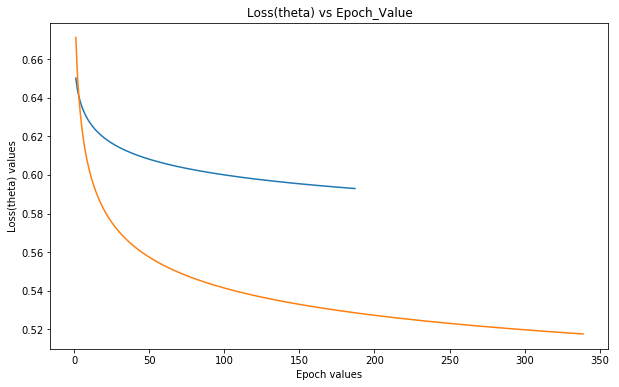

In [120]:
# Plotting Loss(theta) vs num_epochs
plt.figure(figsize=(10,6))
plt.ylabel('Loss(theta) values')
plt.xlabel('Epoch values')
plt.title('Loss(theta) vs Epoch_Value')

plt.plot(epoch_value_list_val, theta_loss_val)
plt.plot(epoch_value_list_train, theta_loss_train)

# Blue Line - Validation Data
# Orange Line - Training Data


In [121]:
# (b) Plot Accuracy vs num_epochs for both training and validation set on the same figure

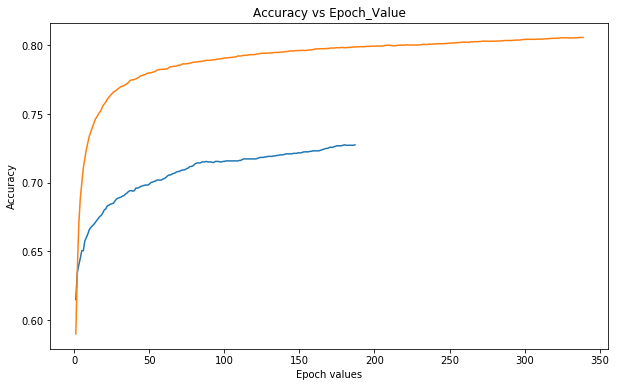

In [122]:
plt.figure(figsize=(10,6))
plt.ylabel('Accuracy')
plt.xlabel('Epoch values')
plt.title('Accuracy vs Epoch_Value')

plt.plot(epoch_value_list_val, acc_per_epoch_val)
plt.plot(epoch_value_list_train, acc_per_epoch_train)

# Blue Line - Validation Data
# Orange Line - Training Data

### 4. ROC and Precision-Recall curves

In [123]:
#(a) Plot ROC curve on validation data

Text(0.5,0,'False Positive Rate')

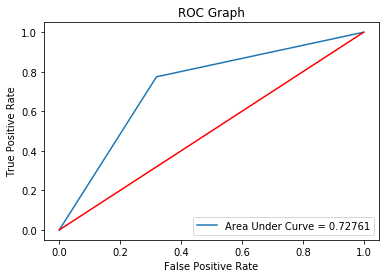

In [124]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_val, pred_val)
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.title('ROC Graph')
plt.plot(false_positive_rate, true_positive_rate, label='Area Under Curve = %0.5f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')

Area under curve = __

In [125]:
print(roc_auc)

0.7276064610866374


Area under curve = 0.7276064610866374

In [126]:
#(a) Plot Precision-Recall curve on validation data

Text(0.5,1,'Precision-Recall curve')

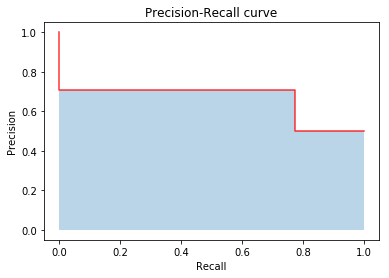

In [184]:
precision, recall, thresholds = precision_recall_curve(y_val, pred_val)
average_precision = average_precision_score(y_val, pred_val)
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.step(recall, precision, color='r', alpha=0.8,
         where='post')
plt.fill_between(recall, precision, alpha=0.3, **step_kwargs)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall curve')

In [129]:
# Average Precision = __

In [185]:
average_precision

0.6611575949304713

Average Precision = 0.6611575949304713

## Question 2.4

### 1. Submission

In [167]:
import pandas as pd
def submission(y_pred):
    """
    generate the submission.csv for kaggle
    input args:
        y_pred: 5542x1 array or list contains 5542 elements
        
    """
    save_file = pd.DataFrame(columns=["Id","Class"])
    id = np.array([idx for idx in range(5542)])
    save_file["Id"] = id
    save_file["Class"]= y_pred
    save_file.to_csv("submission11.csv",index=0)       

#### Generate the submission.csv

In [ ]:
# code goes here

In [ ]:
pred_test_int = list(map(int, pred_val_experiment))

In [ ]:
submission(pred_test_int)

In [ ]:
# Trying different things to improve my score on the leaderboard
# ************* Ignore ********************

In [164]:
LR = LogisticRegression(200, 0.1)
theta_epoch_list_eve, epoch_value_list_eve, theta_loss_list_eve, acc_per_epoch_eve = LR.fit(eve_x, eve_y)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


In [165]:
pred_bool_experiment = LR.predict(X_test)
pred_val_experiment = pred_bool_experiment[0]

In [ ]:
# Till here
# ************* Ignore ********************

Best obtained accuracy on Public Leader-board = __%

In [131]:
# Best obtained accuracy on Public Leader-board = 0.89029

0.89029 -> my best score